# Assortativity analysis

Notebook for testing assortativity analysis in nodes, used to determine certain urban areas with specific clustering structures based on opportunities.

## Import libraries

In [11]:
import odc

import geopandas as gpd
import pandas as pd
import numpy as np
import networkx as nx
import osmnx as ox

import matplotlib.pyplot as plt
import seaborn as sns

import aup

## Add data

### Network data

Nodes

In [2]:
schema = 'projects_research'
table = 'santiago_nodes'

nodes = aup.gdf_from_db(table, schema)
print(nodes.shape)
nodes.head(2)

(270414, 5)


,osmid,x,y,street_count,geometry
0,14609420,-70.754779,-33.515980,3,POINT (-70.75478 -33.51598)
1,14609423,-70.752761,-33.516031,3,POINT (-70.75276 -33.51603)


Edges

In [3]:
schema = 'projects_research'
table = 'santiago_edges'

edges = aup.gdf_from_db(table, schema)
print(edges.shape)
edges.head(2)

(704877, 18)


,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service
0,14609420,448810971,0,279808979,False,2,Corregidor Zañartu,residential,None,39.944,"LINESTRING (-70.75478 -33.51598, -70.75478 -33...",None,None,None,None,None,None,None
1,14609420,14609423,0,986531508,False,2,Cuatro Álamos,secondary,None,187.178,"LINESTRING (-70.75478 -33.51598, -70.75472 -33...",None,None,None,None,None,None,None


### Proximity nodes

In [4]:
schema = 'projects_research'
table = 'santiago_nodesproximity'

nodes_raw = aup.gdf_from_db(table, schema)
print(nodes_raw.shape)
nodes_raw.head(2)

(11093957, 8)


,osmid,source,source_time,source_15min,x,y,geometry,city
0,14609420,clinica_priv,7.005465,6.0,-70.754779,-33.515980,POINT (-70.75478 -33.51598),AM_Santiago
1,266256899,clinica_priv,65.749155,0.0,-70.795942,-33.522296,POINT (-70.79594 -33.5223),AM_Santiago


Data treatment

In [7]:
nodes_prox = nodes.copy()

for source in list(nodes_raw.source.unique()):
    # filter nodes according to source
    nodes_tmp = nodes_raw.loc[nodes_raw.source==source].copy()
    # merge nodes with proximity data with restructured node data
    nodes_prox = nodes_prox.merge(nodes_tmp.drop(columns=['x','y','geometry','city']), 
                             on='osmid', how='left')
    nodes_prox = nodes_prox.rename(columns={'source_time':f'{source}_time',
                                           'source_15min':f'{source}_15min'})
    nodes_prox = nodes_prox.drop(columns=['source'])
    
    del nodes_tmp

In [8]:
print(nodes_prox.shape)
nodes_prox.head(2)

(270414, 91)


,osmid,x,y,street_count,geometry,clinica_priv_time,clinica_priv_15min,clinica_pub_time,clinica_pub_15min,consult_ado_priv_time,...,paradas_tp_masivo_time,paradas_tp_masivo_15min,restaurantes_bar_cafe_time,restaurantes_bar_cafe_15min,viv_social_time,viv_social_15min,local_mini_market_time,local_mini_market_15min,ferias_time,ferias_15min
0,14609420,-70.754779,-33.515980,3,POINT (-70.75478 -33.51598),7.005465,6.0,21.63234,0.0,9.31332,...,12.744885,1.0,5.425845,37.0,6.52719,34.0,7.98183,17.0,9.20229,1.0
1,14609423,-70.752761,-33.516031,3,POINT (-70.75276 -33.51603),8.175150,6.0,19.84779,0.0,12.12099,...,15.310575,0.0,8.233515,24.0,8.07789,43.0,6.39741,12.0,6.39462,1.0


<Axes: >

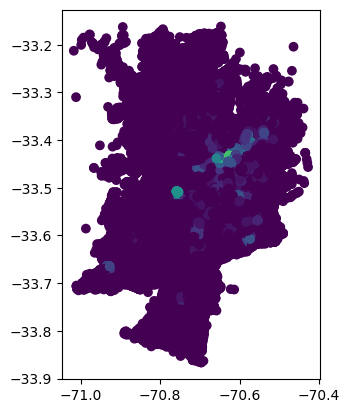

In [9]:
nodes_prox.plot('clinica_priv_15min')

## Assortivity analysis

Create Graph

In [15]:
if 'osmid' in nodes.columns:
    nodes = nodes.set_index('osmid')
if 'u' in edges.columns:
    edges = edges.set_index(['u','v','key'])

In [16]:
G = ox.graph_from_gdfs(nodes, edges)

Set attributes to the nodes

In [24]:
if 'osmid' in nodes_prox.columns:
    nodes_prox = nodes_prox.set_index('osmid')

In [66]:
nodes_prox.head(1)

,x,y,street_count,geometry,clinica_priv_time,clinica_priv_15min,clinica_pub_time,clinica_pub_15min,consult_ado_priv_time,consult_ado_priv_15min,...,paradas_tp_masivo_time,paradas_tp_masivo_15min,restaurantes_bar_cafe_time,restaurantes_bar_cafe_15min,viv_social_time,viv_social_15min,local_mini_market_time,local_mini_market_15min,ferias_time,ferias_15min
osmid,,,,,,,,,,,,,,,,,,,,,
14609420,-70.754779,-33.51598,3,POINT (-70.75478 -33.51598),7.005465,6.0,21.63234,0.0,9.31332,2.0,...,12.744885,1.0,5.425845,37.0,6.52719,34.0,7.98183,17.0,9.20229,1.0


In [42]:
nodes_prox = nodes_prox.fillna(0)

In [48]:
nodes_prox.clinica_priv_15min.unique()

array([ 6.,  5.,  8.,  0.,  1.,  2.,  3.,  4.,  7.,  9., 10., 18., 19.,
       20., 16., 14., 13., 11., 12., 15., 17.])

In [61]:
nx.set_node_attributes(G, nodes_prox.drop(columns=['x','y','street_count',
                                                  'geometry']).to_dict(orient='index'))

City wide testing for clinica_priv assortativity

In [64]:
M_ = nx.attribute_mixing_matrix(G, 'clinica_priv_15min')

In [67]:
# NX computation
nx.attribute_assortativity_coefficient(G, 'clinica_priv_15min')

0.8944892247345128


In [71]:
for source_count in nodes_prox.columns.unique():
    if '_15min' in source_count:
        print(source_count, nx.attribute_assortativity_coefficient(G, source_count))

clinica_priv_15min 0.8944892247345128
clinica_pub_15min 0.9076538337027847
consult_ado_priv_15min 0.9205612138103261
consult_ado_pub_15min 0.9576277640567266
hospital_priv_15min 0.9532566720678342
hospital_pub_15min 0.9382452357590793
vacunatorio_priv_15min 0.9465001845785718
vacunatorio_pub_15min 0.9639118124516074
carniceria_15min 0.8499767153278687
edu_basica_priv_15min 0.8996365860226204
edu_basica_pub_15min 0.7728413247050798
edu_media_priv_15min 0.9057273961734547
edu_media_pub_15min 0.8439729347874626
universidad_15min 0.8706220923923084
farmacia_15min 0.7538567786623435
museos_priv_15min 0.932836771427067
museos_pub_15min 0.9269642673823563
paradas_tp_15min 0.46395890374425075
sitios_historicos_15min 0.8913745854113765
bibliotecas_15min 0.9416284413534111
edu_adultos_priv_15min 0.9599030356554257
edu_adultos_pub_15min 0.9154993867934399
edu_especial_priv_15min 0.9509839474508094
edu_especial_pub_15min 0.84813478667375
eq_deportivo_priv_15min 0.8086530471738108
eq_deportivo_pub_

In [72]:
for source_count in nodes_prox.columns.unique():
    if '_15min' in source_count:
        print(source_count, nx.numeric_assortativity_coefficient(G, source_count))

clinica_priv_15min 0.988685020917558
clinica_pub_15min 0.9561822504854826
consult_ado_priv_15min 0.9852195982455431
consult_ado_pub_15min 0.9576278001486495
hospital_priv_15min 0.9621643546906135
hospital_pub_15min 0.9732799762523331
vacunatorio_priv_15min 0.9771444307797134
vacunatorio_pub_15min 0.9639118124515994
carniceria_15min 0.9774614538935584
edu_basica_priv_15min 0.983383937602416
edu_basica_pub_15min 0.9807112310101243
edu_media_priv_15min 0.9822818349018472
edu_media_pub_15min 0.9755615935301544
universidad_15min 0.9952043478693625
farmacia_15min 0.9944260221247296
museos_priv_15min 0.984621197341194
museos_pub_15min 0.9846265170261126
paradas_tp_15min 0.9926036594040623
sitios_historicos_15min 0.9958574212145037
bibliotecas_15min 0.9457577459095262
edu_adultos_priv_15min 0.9702631368896842
edu_adultos_pub_15min 0.9623116310579662
edu_especial_priv_15min 0.9509839474508084
edu_especial_pub_15min 0.9748488106087152
eq_deportivo_priv_15min 0.9781526265817057
eq_deportivo_pub_1